# Recommend movies through posters via transfer learning

- Scrape movies posters online
- Use transfer learning from Inception-v3 model to extract features
- Use KNN to cluster similar movie posters for users

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import requests  
import re
from bs4 import BeautifulSoup 

from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
print('max_rows:' , pd.options.display.max_rows)
print('max_columns:' , pd.options.display.max_columns)
%matplotlib inline 

max_rows: 60
max_columns: 999


In [2]:
movie = pd.read_csv('~/movie_metadata.csv') 
movie.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
movie.isna().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [4]:
movie = movie.dropna()
movie_link = movie['movie_imdb_link'].tolist()

In [8]:
from tqdm import tqdm
imdbURLS = movie_link

records = [] 
for x in tqdm(imdbURLS): 
    # title
    title = re.search('/title/(.*)/', x)
    imdbID = title.group(1)
    # web scraping
    r = requests.get(x)
    soup = BeautifulSoup(r.text, 'html.parser')  
    results = soup.find_all('div', attrs={'class':'poster'})  
    first_result = results[0]  
    postername = first_result.find('img')['alt'] 
    imgurl = first_result.find('img')['src'] 
    records.append((imdbID, x, postername, imgurl))

100%|██████████| 3756/3756 [59:50<00:00,  1.14s/it]  


In [9]:
print(len(records) )
records[:5]

3756


[('tt0499549',
  'http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1',
  'Avatar Poster',
  'https://m.media-amazon.com/images/M/MV5BMTYwOTEwNjAzMl5BMl5BanBnXkFtZTcwODc5MTUwMw@@._V1_UX182_CR0,0,182,268_AL_.jpg'),
 ('tt0449088',
  'http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1',
  "Pirates of the Caribbean: At World's End Poster",
  'https://m.media-amazon.com/images/M/MV5BMjIyNjkxNzEyMl5BMl5BanBnXkFtZTYwMjc3MDE3._V1_UX182_CR0,0,182,268_AL_.jpg'),
 ('tt2379713',
  'http://www.imdb.com/title/tt2379713/?ref_=fn_tt_tt_1',
  'Spectre Poster',
  'https://m.media-amazon.com/images/M/MV5BOWQ1MDE1NzgtNTQ4OC00ZjliLTllZDAtN2IyOTVmMTc5YjUxXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_UX182_CR0,0,182,268_AL_.jpg'),
 ('tt1345836',
  'http://www.imdb.com/title/tt1345836/?ref_=fn_tt_tt_1',
  'The Dark Knight Rises Poster',
  'https://m.media-amazon.com/images/M/MV5BMTk4ODQzNDY3Ml5BMl5BanBnXkFtZTcwODA0NTM4Nw@@._V1_UX182_CR0,0,182,268_AL_.jpg'),
 ('tt0401729',
  'http://www.imdb.com/title/tt0401729/?ref_=fn

In [11]:
df = pd.DataFrame(records, columns=['imdbID', 'url', 'postername', 'movie_imdb_link'])
df.columns = ['imdbID','movie_imdb_link','postername','poster_imdb_link']
df.head()

,imdbID,movie_imdb_link,postername,poster_imdb_link
0,tt0499549,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar Poster,https://m.media-amazon.com/images/M/MV5BMTYwOT...
1,tt0449088,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,Pirates of the Caribbean: At World's End Poster,https://m.media-amazon.com/images/M/MV5BMjIyNj...
2,tt2379713,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,Spectre Poster,https://m.media-amazon.com/images/M/MV5BOWQ1MD...
3,tt1345836,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,The Dark Knight Rises Poster,https://m.media-amazon.com/images/M/MV5BMTk4OD...
4,tt0401729,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,John Carter Poster,https://m.media-amazon.com/images/M/MV5BMDEwZm...


In [12]:
print(df.shape)
print(movie.shape)
total = pd.merge(movie, df, on = 'movie_imdb_link', how='left')
print(total.shape)

(3756, 4)
(3756, 28)
(3968, 31)


In [13]:
df_poster = df[['imdbID','poster_imdb_link']]

In [14]:
df_poster.head()

,imdbID,poster_imdb_link
0,tt0499549,https://m.media-amazon.com/images/M/MV5BMTYwOT...
1,tt0449088,https://m.media-amazon.com/images/M/MV5BMjIyNj...
2,tt2379713,https://m.media-amazon.com/images/M/MV5BOWQ1MD...
3,tt1345836,https://m.media-amazon.com/images/M/MV5BMTk4OD...
4,tt0401729,https://m.media-amazon.com/images/M/MV5BMDEwZm...


In [17]:
savelocation = '~poster/'

import urllib
from urllib.request import urlretrieve

In [18]:
for index, row in tqdm(df_poster.iterrows()):
    url = row['poster_imdb_link']
    id = row['imdbID']
    jpgname = savelocation+id+'.jpg'
    urllib.request.urlretrieve(url, jpgname)

3756it [06:21,  9.83it/s]


# Transfer learning from Inception-v3 tp extract features of images

In [20]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input

from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [21]:
#selectedlayer = "custom"
base_model = InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model= Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [24]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

directory = '~poster/'
feature_list = []

for name in listdir(directory):
    filename = directory + '/' + name
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)   
    image_id = name.split('.')[0]
    
    feature = model.predict(image).ravel()
    feature_np = np.array(feature)
    feature_list.append(feature_np.flatten())

inceptionv3_feature_list_np = np.array(feature_list)

In [25]:
def load_photos_predict(directory):
    images = []
    for name in listdir(directory)
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        image_id = name.split('.')[0]
        feature = model.predict(image).ravel()
        images.append(image_id)
    return images

In [26]:
inceptionv3_feature_list_np

array([[0.        , 0.5043725 , 0.        , ..., 0.07068965, 0.        ,
        1.4652598 ],
       [0.        , 0.6766838 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14193112, 0.        , 0.        , ..., 1.0419029 , 0.        ,
        0.9369256 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.437524  , 1.3100384 ,
        0.82648957],
       [0.        , 0.32313603, 0.        , ..., 1.8174018 , 0.        ,
        0.7347988 ],
       [0.        , 0.        , 0.49075124, ..., 3.2087798 , 1.2338617 ,
        1.2682848 ]], dtype=float32)

In [27]:
# Choose the most nearest 6 movie posters as recommendation
nn_num = 6
X = list(inceptionv3_feature_list_np)
nbrs = NearestNeighbors(n_neighbors=nn_num, algorithm='ball_tree', metric='euclidean', n_jobs = -1).fit(X)

In [28]:
nn_array = nbrs.kneighbors_graph(X).toarray()
nn = pd.DataFrame(nn_array)
nn.columns = load_photos_predict(directory)

In [30]:
col_set = {}

for i in range(len(nn)):
    chosen = []
    for col in nn.columns:
        if nn.iloc[i][col]== 1: 
            chosen.append(col)
    col_set[i] = chosen

In [31]:
col_set

{0: ['tt1477076',
  'tt0125664',
  'tt0390538',
  'tt1270262',
  'tt0477347',
  'tt0473444'],
 1: ['tt2381941',
  'tt1409024',
  'tt0279113',
  'tt0814314',
  'tt0125664',
  'tt0790712'],
 2: ['tt0186151',
  'tt0279113',
  'tt0125664',
  'tt2243537',
  'tt0367479',
  'tt0113627'],
 3: ['tt0056172',
  'tt0083943',
  'tt0019729',
  'tt0062512',
  'tt0120857',
  'tt0059113'],
 4: ['tt0299977',
  'tt0331632',
  'tt0245712',
  'tt0108255',
  'tt0099582',
  'tt0187696'],
 5: ['tt0795438',
  'tt0279113',
  'tt0491152',
  'tt0390538',
  'tt0086066',
  'tt0036868'],
 6: ['tt1762399',
  'tt0076175',
  'tt0044672',
  'tt0887883',
  'tt0036868',
  'tt0102070'],
 7: ['tt0083001',
  'tt0019729',
  'tt0107983',
  'tt0390538',
  'tt0044672',
  'tt0119346'],
 8: ['tt0266747',
  'tt0055928',
  'tt1230414',
  'tt0887883',
  'tt0119346',
  'tt0465142'],
 9: ['tt0114369',
  'tt0081398',
  'tt2582802',
  'tt0245712',
  'tt0113627',
  'tt0102070'],
 10: ['tt1007028',
  'tt0279113',
  'tt0323939',
  'tt024250

In [33]:
# import json
# with open('~recommend5.txt', 'w') as outfile:
#     json.dump(col_set, outfile)
    
with open('~recommend5.txt') as json_file:
    recommend5 = json.load(json_file)

Text(0.5, 1.0, 'tt0454945')

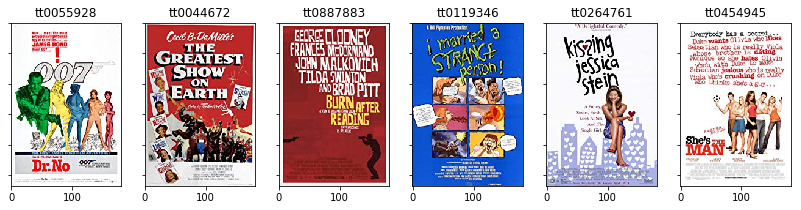

In [34]:
directory = '~poster/'

def udfidfpathh(directory):
    paths = []
    for i in recommend5['3109']: 
        filename = directory + i + '.jpg'
        paths.append(filename)
    return paths


paths2 = udfidfpathh(directory)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, figsize=(14,3))
# Doing each of these manually (ugh)
ax1.imshow(mpimg.imread(paths2[0]))
ax1.set_title(paths2[0].split('/')[-1].split('.')[0])
ax1.set_yticklabels([])
ax2.imshow(mpimg.imread(paths2[1]))
ax2.set_title(paths2[1].split('/')[-1].split('.')[0])
ax3.imshow(mpimg.imread(paths2[2]))
ax3.set_title(paths2[2].split('/')[-1].split('.')[0])
ax4.imshow(mpimg.imread(paths2[3]))
ax4.set_title(paths2[3].split('/')[-1].split('.')[0])
ax5.imshow(mpimg.imread(paths2[4]))
ax5.set_title(paths2[4].split('/')[-1].split('.')[0])
ax6.imshow(mpimg.imread(paths2[5]))
ax6.set_title(paths2[5].split('/')[-1].split('.')[0])

Text(0.5, 1.0, 'tt0059113')

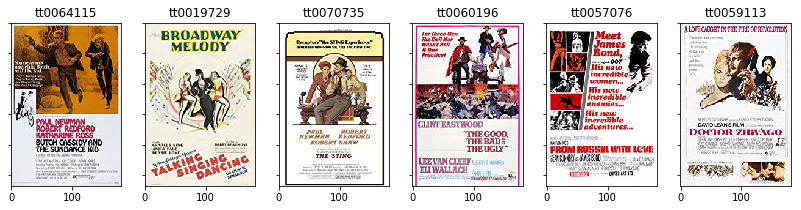

In [35]:
# Broadway style movie posters all have white background with a long list of names.

directory = '~poster/'

def udfidfpathh(directory):
    paths = []
    for i in recommend5['414']: 
        filename = directory + i + '.jpg'
        paths.append(filename)
    return paths


paths2 = udfidfpathh(directory)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, figsize=(14,3))
# Doing each of these manually (ugh)
ax1.imshow(mpimg.imread(paths2[0]))
ax1.set_title(paths2[0].split('/')[-1].split('.')[0])
ax1.set_yticklabels([])
ax2.imshow(mpimg.imread(paths2[1]))
ax2.set_title(paths2[1].split('/')[-1].split('.')[0])
ax3.imshow(mpimg.imread(paths2[2]))
ax3.set_title(paths2[2].split('/')[-1].split('.')[0])
ax4.imshow(mpimg.imread(paths2[3]))
ax4.set_title(paths2[3].split('/')[-1].split('.')[0])
ax5.imshow(mpimg.imread(paths2[4]))
ax5.set_title(paths2[4].split('/')[-1].split('.')[0])
ax6.imshow(mpimg.imread(paths2[5]))
ax6.set_title(paths2[5].split('/')[-1].split('.')[0])

Text(0.5, 1.0, 'tt0107978')

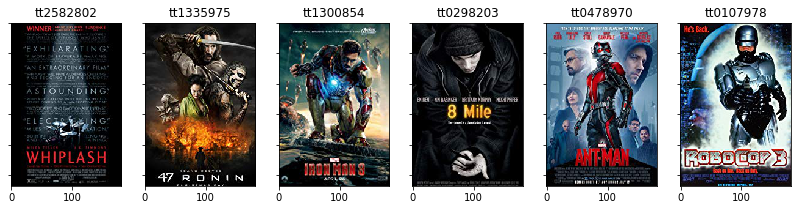

In [36]:
# Sci-fi style movie posters all have dark frame with bright in the center i.e. face of heros.
directory = '/Users/diana_liu/Documents/RecommenderSystem/poster/'

def udfidfpathh(directory):
    paths = []
    for i in recommend5['416']: 
        filename = directory + i + '.jpg'
        paths.append(filename)
    return paths


paths2 = udfidfpathh(directory)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=6, sharex=True, sharey=True, figsize=(14,3))
# Doing each of these manually (ugh)
ax1.imshow(mpimg.imread(paths2[0]))
ax1.set_title(paths2[0].split('/')[-1].split('.')[0])
ax1.set_yticklabels([])
ax2.imshow(mpimg.imread(paths2[1]))
ax2.set_title(paths2[1].split('/')[-1].split('.')[0])
ax3.imshow(mpimg.imread(paths2[2]))
ax3.set_title(paths2[2].split('/')[-1].split('.')[0])
ax4.imshow(mpimg.imread(paths2[3]))
ax4.set_title(paths2[3].split('/')[-1].split('.')[0])
ax5.imshow(mpimg.imread(paths2[4]))
ax5.set_title(paths2[4].split('/')[-1].split('.')[0])
ax6.imshow(mpimg.imread(paths2[5]))
ax6.set_title(paths2[5].split('/')[-1].split('.')[0])